In [1]:
from icalendar import Calendar
from datetime import datetime, timezone, timedelta
from icalendar.prop import vText, vDDDTypes, vCalAddress
from pytz import timezone

import pandas as pd
import matplotlib.pyplot as plt

# Export Calendar as *.ics file

CALENDAR_EXPLORT_FIlE_NAME = 'sitesh@tiqets.com.ics'

# Load calendar in pandas dataframe

g = open(CALENDAR_EXPLORT_FIlE_NAME, 'rb')
gcal = Calendar.from_ical(g.read())

TIMEZONE = str(next(x.get('TZID') for x in gcal.subcomponents if x.name == 'VTIMEZONE'))
gcal_events = filter(lambda component: component.name == 'VEVENT', gcal.subcomponents)

df = pd.DataFrame(gcal_events)

g.close()

# Parse dataframe into appropriate data types

for col in ['DTSTART', 'DTEND', 'CREATED', 'LAST-MODIFIED']:
    df[col] = pd.to_datetime(df[col].apply(vDDDTypes.from_ical), utc=True).dt.tz_convert(TIMEZONE)

for col in ['SUMMARY', 'DESCRIPTION', 'STATUS', 'LOCATION']:
    df[col] = df[col].astype('string')

# Clean-up calendar events outside of employment window
df = df.loc[(df.DTSTART > timezone(TIMEZONE).localize(datetime(2018, 7, 1))) & (df.DTSTART < timezone(TIMEZONE).localize(datetime(2020, 7, 1)))]

# Clean-up calendar events > 12 hours
df = df.loc[(df.DTEND - df.DTSTART) < timedelta(hours=12)]

df.head()

,DTSTART,DTEND,DTSTAMP,ORGANIZER,UID,ATTENDEE,CREATED,DESCRIPTION,LAST-MODIFIED,LOCATION,...,X-APPLE-SUGGESTION-INFO-CHANGED-FIELDS,X-APPLE-SUGGESTION-INFO-OPAQUE-KEY,X-APPLE-SUGGESTION-INFO-TIMESTAMP,X-APPLE-SUGGESTION-INFO-UNIQUE-KEY,CLASS,X-APPLE-STRUCTURED-LOCATION,RRULE,EXDATE,ATTACH,X-MICROSOFT-CDO-OWNERAPPTID
0,2018-07-16 13:00:00+02:00,2018-07-16 14:00:00+02:00,<icalendar.prop.vDDDTypes object at 0x110277190>,mailto:marijn@tiqets.com,2epn518b446lm9nvk300a659hg@google.com,"[mailto:sitesh@tiqets.com, mailto:marijn@tiqet...",2018-07-16 10:19:37+02:00,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,2018-07-16 13:10:02+02:00,HQ-4-Lunchroom-Room 'Amsterdam' (6),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-20 13:00:00+02:00,2018-07-20 14:00:00+02:00,<icalendar.prop.vDDDTypes object at 0x1208400a0>,mailto:anita@tiqets.com,3u0js13i0srt3btnv67hnd596e@google.com,"[mailto:sitesh@tiqets.com, mailto:yuri@tiqets....",2018-07-17 11:02:34+02:00,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,2018-07-18 11:02:37+02:00,HQ-4-tech side-Room 'Paris' (6) [Screen],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-18 13:00:00+02:00,2018-07-18 14:00:00+02:00,<icalendar.prop.vDDDTypes object at 0x1208406d0>,NaN,7061F351-AED1-45A7-8027-FE69D09E91D3,NaN,2018-07-18 11:59:04+02:00,,2018-07-18 12:50:12+02:00,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-07-18 16:30:00+02:00,2018-07-18 17:30:00+02:00,<icalendar.prop.vDDDTypes object at 0x120840d90>,mailto:sitesh@tiqets.com,9451C059-8DDC-4669-A8E1-1D4D022C8430,"[mailto:sitesh@tiqets.com, mailto:tjerk@tiqets...",2018-07-18 11:59:22+02:00,,2018-07-18 16:56:34+02:00,HQ-4-Lunchroom-Room 'Amsterdam' (6),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-19 11:15:00+02:00,2018-07-19 12:00:00+02:00,<icalendar.prop.vDDDTypes object at 0x1208365b0>,mailto:sitesh@tiqets.com,2pmeel7d442aha0d6lpmjaf3pe@google.com,"[mailto:sandra@tiqets.com, mailto:sitesh@tiqet...",2018-07-17 11:17:19+02:00,-::~:~::~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:~:...,2018-07-19 09:55:49+02:00,HQ-4-tech side-Room 'Rome' (6),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Plot overall number of meetings, time spent in meetings & people met

# Meeting count
print('# Overall Meetings \t:', df.shape[0])
print('# Recurring meetings \t:', df.RRULE.dropna().shape[0])

# Time spent
print()
print('Σ Overall meeting hours \t:', (df.DTEND - df.DTSTART).sum().total_seconds() / 60 / 60)
print('# Overall meeting days \t:', df.DTSTART.dt.date.nunique())

# People met
print()
print('# Overall people met \t:', df.explode('ATTENDEE', ignore_index=True)['ATTENDEE'].value_counts().size)

# Overall Meetings 	: 848
# Recurring meetings 	: 184

Σ Overall meeting hours 	: 712.6333333333333
# Overall meeting days 	: 392

# Overall people met 	: 264


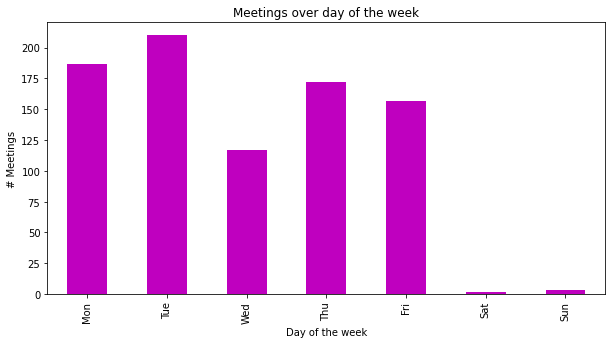

In [3]:
# Plot trend of meetings over day of the week

from matplotlib.ticker import FuncFormatter

plt.figure()
ax = (df['DTSTART'].dt.dayofweek.value_counts()).sort_index().plot(
    kind='bar',
    color='m',
    figsize=(10,5),
    ylabel='# Meetings',
    xlabel='Day of the week',
    title='Meetings over day of the week'
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda tick, _: ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][tick]))

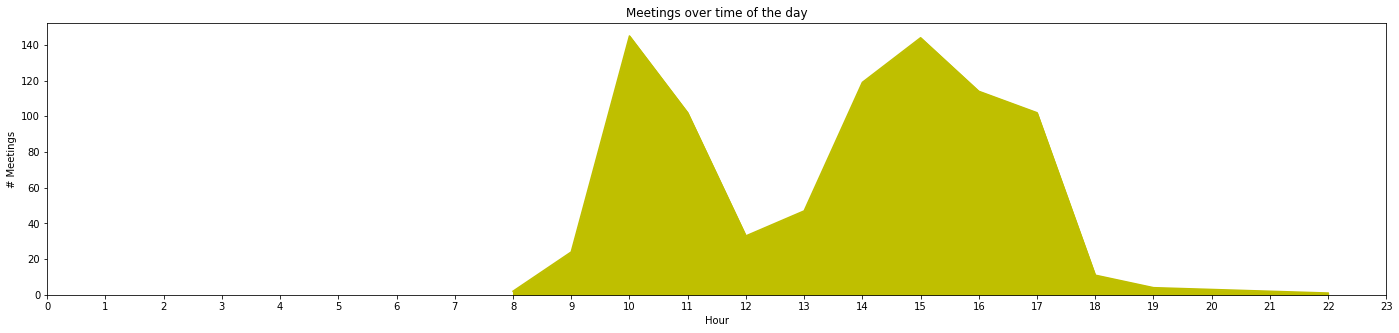

In [4]:
# Plot trend of meetings across time of the day

plt.figure()
ax = (df['DTSTART'].dt.hour.value_counts()).sort_index().plot(
    kind='area',
    color='y',
    figsize=(24, 5),
    ylabel='# Meetings',
    xlabel='Hour',
    xticks=range(0, 24),
    title='Meetings over time of the day'
)

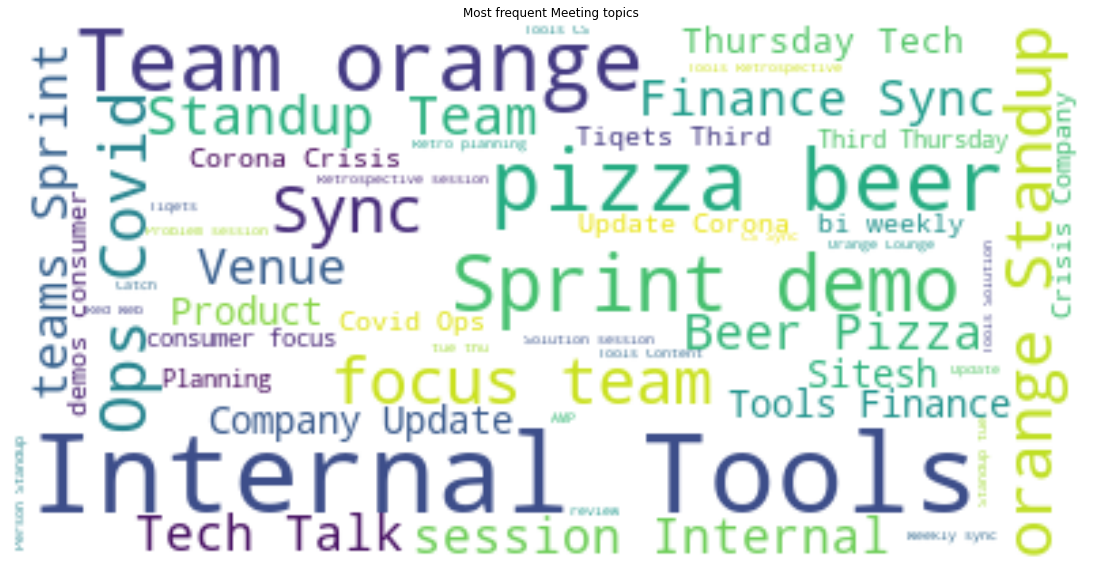

In [5]:
# Generate word cloud of meeting titles

from wordcloud import WordCloud

summary_wordcloud = WordCloud(
    background_color='white',
    max_words=50,
#     min_font_size=10, 
#     max_font_size=30
).generate_from_text(df.SUMMARY.to_string())

plt.figure(figsize=(20,10))
plt.title('Most frequent Meeting topics')
plt.imshow(summary_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

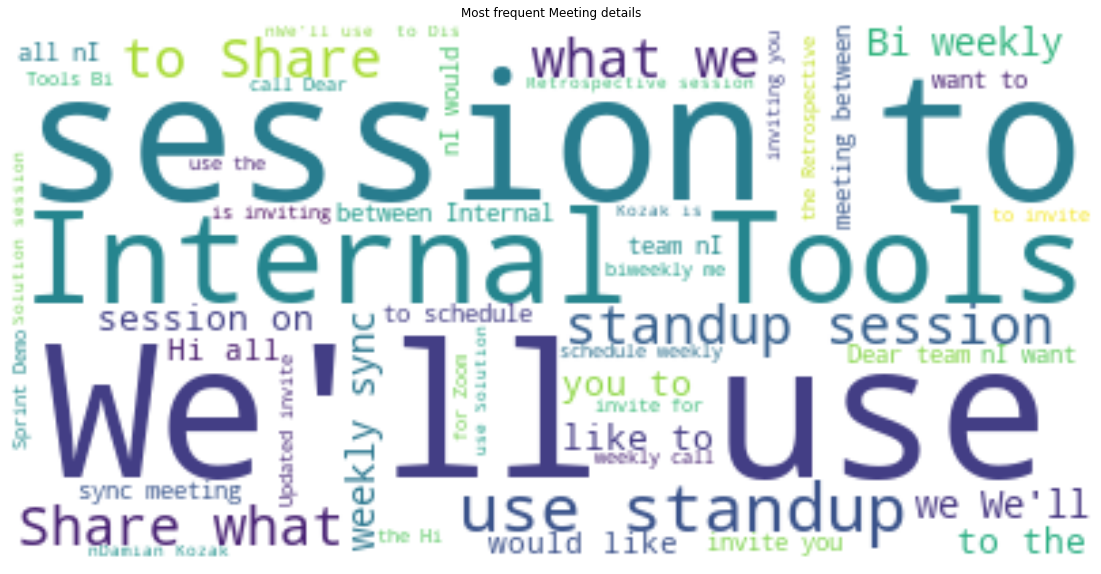

In [6]:
# Generate word cloud of meeting details

description_wordcloud = WordCloud(
    background_color='white', 
    stopwords = ['http', 'https', 'nbsp', 'href', 'src', '×', '!--...--', '!DOCTYPE', 'a', 'abbr', 'acronym', 'abbr', 'address', 'applet', 'embed', 'object', 'area', 'article', 'aside', 'audio', 'b', 'base', 'basefont', 'bdi', 'bdo', 'big', 'blockquote', 'body', 'br', 'button', 'canvas', 'caption', 'center', 'cite', 'code', 'col', 'colgroup', 'data', 'datalist', 'dd', 'del', 'details', 'dfn', 'dialog', 'dir', 'ul', 'div', 'dl', 'dt', 'em', 'embed', 'fieldset', 'figcaption', 'figure', 'font', 'footer', 'form', 'frame', 'frameset', 'h1 to h6', 'head', 'header', 'hr', 'html', 'i', 'iframe', 'img', 'input', 'ins', 'kbd', 'label', 'legend', 'li', 'link', 'main', 'map', 'mark', 'meta', 'meter', 'nav', 'noframes', 'noscript', 'object', 'ol', 'optgroup', 'option', 'output', 'p', 'param', 'picture', 'pre', 'progress', 'q', 'rp', 'rt', 'ruby', 's', 'samp', 'script', 'section', 'select', 'small', 'source', 'span', 'strike'],
    max_words=50,
#     min_font_size=10, 
#     max_font_size=30
).generate_from_text(df.DESCRIPTION.str.rsplit('-::~:~::~:~:').str.get(0).to_string())

plt.figure(figsize=(20,10))
plt.title('Most frequent Meeting details')
plt.imshow(description_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

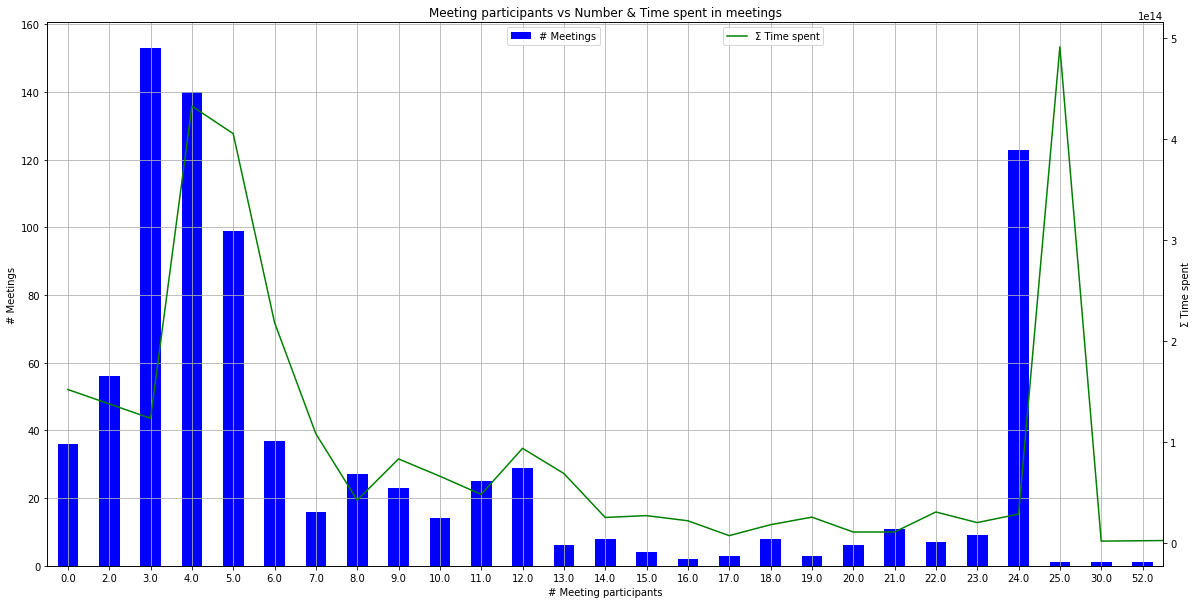

In [7]:
# Plot number of participants x time spent & count of meetings

df['attendee_count'] = df.ATTENDEE.str.len().fillna(0)
df['meeting_duration'] = (df.DTEND - df.DTSTART)

plt.figure(figsize=(20, 10))
plt.title('Meeting participants vs Number & Time spent in meetings')
meeting_attendee_axis = df.groupby(['attendee_count'])['meeting_duration'].count().plot(
    kind='bar',
    color='blue',
    grid=True
)

df.groupby(['attendee_count'])['meeting_duration'].sum().plot(
    kind='line',
    color='green',
    ax=meeting_attendee_axis,
    grid=True,
    secondary_y=True
)

meeting_attendee_axis.set_xlabel('# Meeting participants')

meeting_attendee_axis.set_ylabel('# Meetings')
meeting_attendee_axis.legend(['# Meetings'], bbox_to_anchor=(0.5, 1.0))

meeting_attendee_axis.right_ax.set_ylabel('Σ Time spent')
meeting_attendee_axis.right_ax.legend(['Σ Time spent'], bbox_to_anchor=(0.7, 1.0))

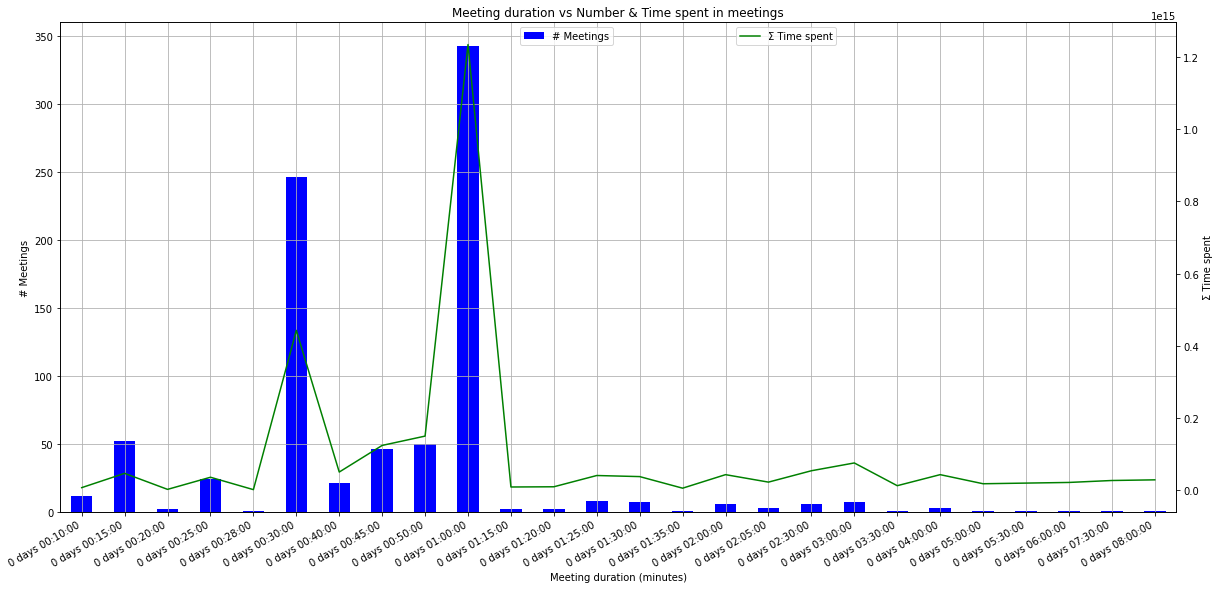

In [8]:
# Plot meeting duration x time spent & count of meetings

df_duration = df.meeting_duration.value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.title('Meeting duration vs Number & Time spent in meetings')

meeting_duration_axis = df_duration.plot(
    kind='bar',
    color='blue',
    grid=True
)

for key, value in df_duration.iteritems():
    df_duration[key] *= key

df_duration.plot(
    kind='line',
    color='green',
    ax=meeting_duration_axis,
    grid=True,
    secondary_y=True
)

meeting_duration_axis.set_xlabel('Meeting duration (minutes)')

meeting_duration_axis.set_ylabel('# Meetings')
meeting_duration_axis.legend(['# Meetings'], bbox_to_anchor=(0.5, 1.0))

meeting_duration_axis.right_ax.set_ylabel('Σ Time spent')
meeting_duration_axis.right_ax.legend(['Σ Time spent'], bbox_to_anchor=(0.7, 1.0))
meeting_duration_axis.right_ax.format_ydata = lambda x: (td.seconds // 60) % 60

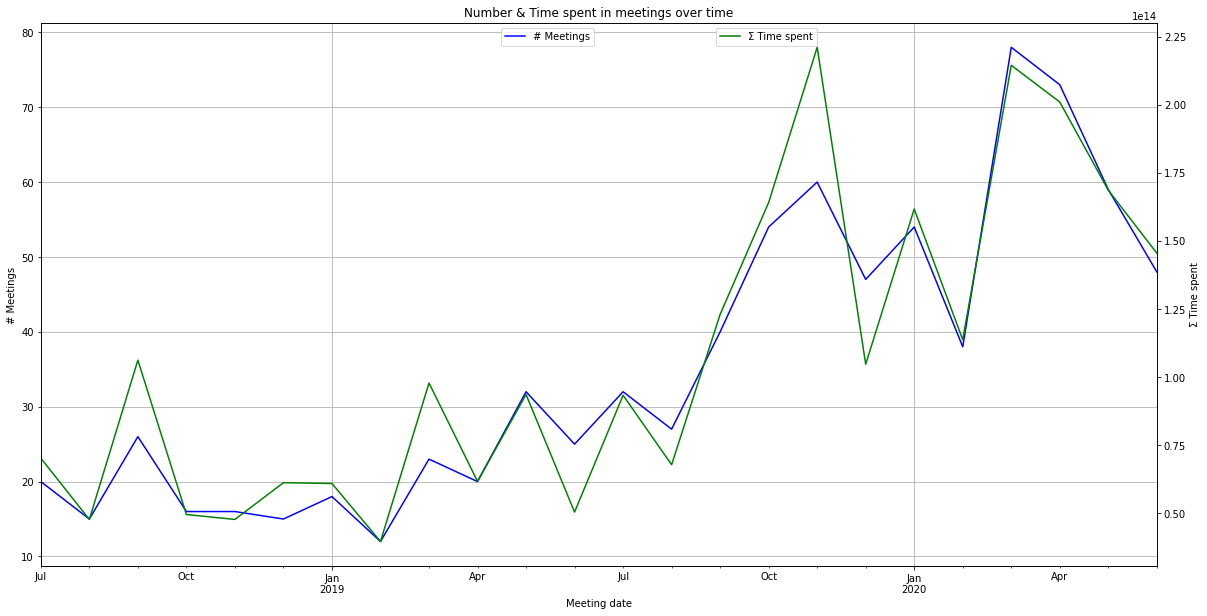

In [9]:
# Plot number of meetings & time spent over time

plt.figure(figsize=(20, 10))
plt.title('Number & Time spent in meetings over time')

df_meeting_timeline = df.resample('M', on='DTSTART').agg({'DTEND': 'count', 'meeting_duration': 'sum'})

meeting_date_axis = df_meeting_timeline['DTEND'].plot(
    kind='line',
    color='blue',
    grid=True
)

df_meeting_timeline['meeting_duration'].plot(
    kind='line',
    color='green',
    ax=meeting_date_axis,
    grid=True,
    secondary_y=True
)

meeting_date_axis.set_xlabel('Meeting date')

meeting_date_axis.set_ylabel('# Meetings')
meeting_date_axis.legend(['# Meetings'], bbox_to_anchor=(0.5, 1.0))

meeting_date_axis.right_ax.set_ylabel('Σ Time spent')
meeting_date_axis.right_ax.legend(['Σ Time spent'], bbox_to_anchor=(0.7, 1.0))
meeting_date_axis.right_ax.format_ydata = lambda x: (td.seconds // 60) % 60

<AxesSubplot:title={'center':'Overall meeting place location'}, ylabel='Meeting location'>

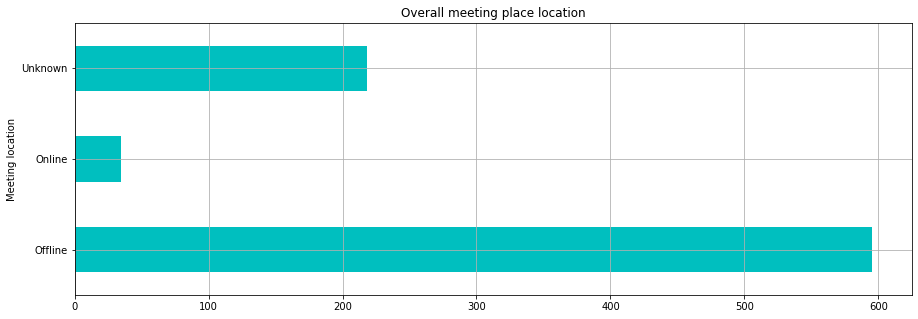

In [10]:
# Plot location of meeting (online : offline) x number & time spent in meetings

def get_location(location):
    if 'http' in location:
        return 'Online'
    elif location:
        return 'Offline'
    else:
        return 'Unknown'

df['meeting_location'] = df['LOCATION'].apply(lambda location: get_location(location.strip()))

plt.figure(figsize=(15,5))
df.groupby(['meeting_location'])['meeting_duration'].count().plot(
    kind='barh', 
    grid=True,
    color='c',
    ylabel='# Meetings',
    xlabel='Meeting location',
    title='Overall meeting place location'
)

# plt.figure(figsize=(15,5))
# df.groupby(['meeting_location'])['meeting_duration'].sum().plot(
#     kind='bar', 
#     grid=True,
#     color='green',
#     ylabel='Σ Time spent', 
#     xlabel='Meeting location'
# )

<AxesSubplot:title={'center':'Meeting place location over time'}, xlabel='Meeting time', ylabel='# Meetings'>

<Figure size 432x288 with 0 Axes>

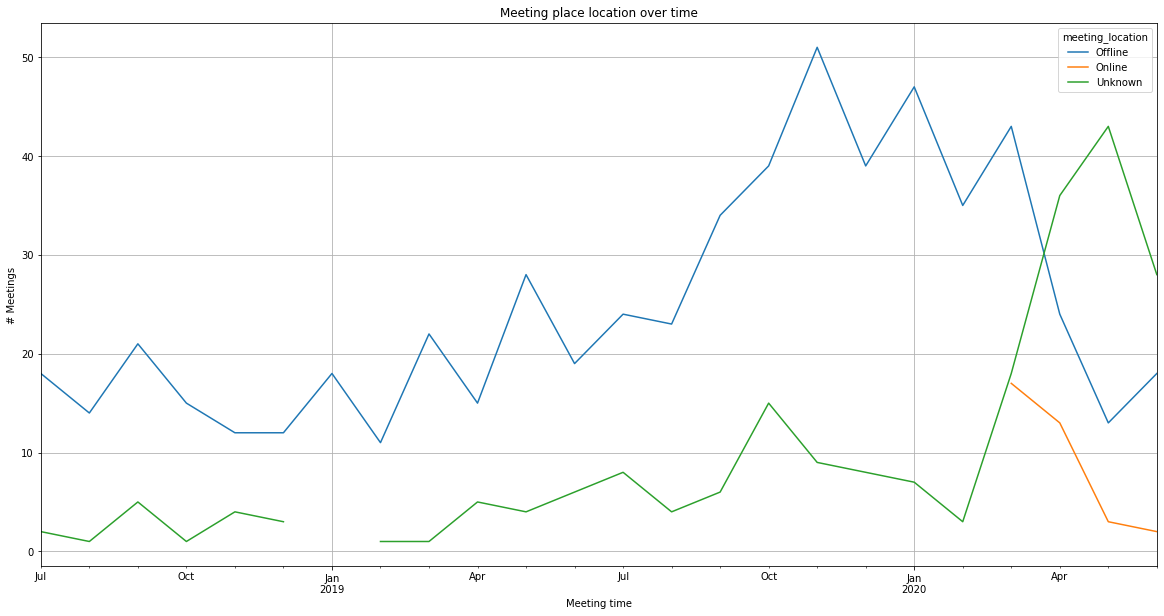

In [11]:
# Plot total ratio of online : offline meetings over time

df_location_timeline = df.groupby(
    [pd.Grouper(freq='1M', key='DTSTART'), 'meeting_location']
).agg({
    'DTEND': 'count',
    'meeting_duration': 'sum'
}).unstack()

plt.figure()
df_location_timeline['DTEND'].plot(
    kind='line',
    grid=True,
    figsize=(20, 10),
    title='Meeting place location over time',
    ylabel='# Meetings',
    xlabel='Meeting time'
)

# plt.figure()
# df_location_timeline['meeting_duration'].plot(
#     kind='line',
#     grid=True,
#     figsize=(20, 10),
#     ylabel='Σ Time spent',
#     xlabel='Meeting location'
# )

<AxesSubplot:title={'center':'Most common participants in meetings attended'}, ylabel='Meeting attendee'>

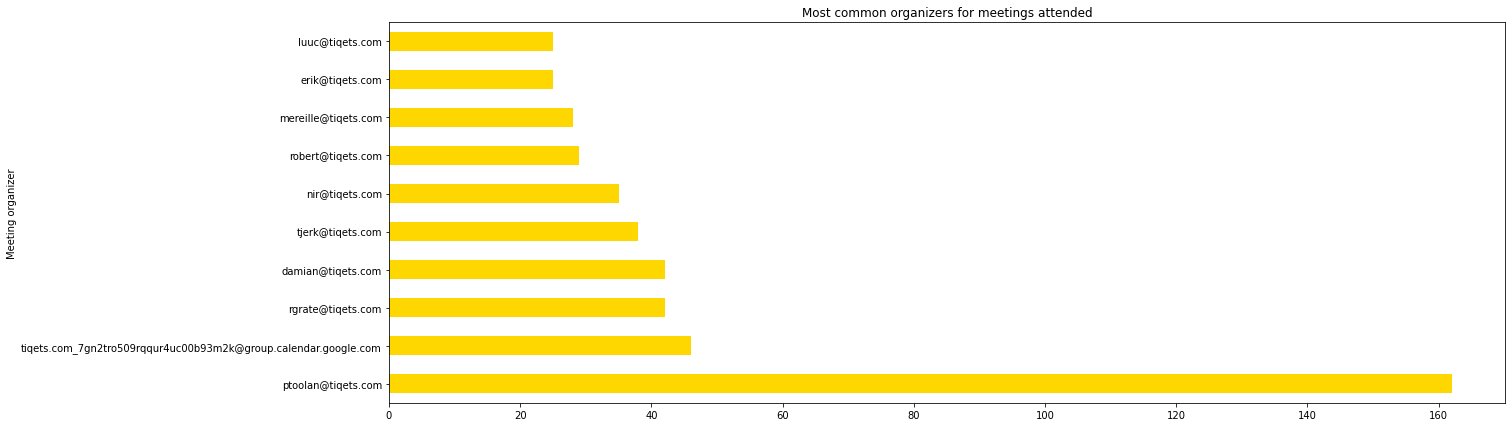

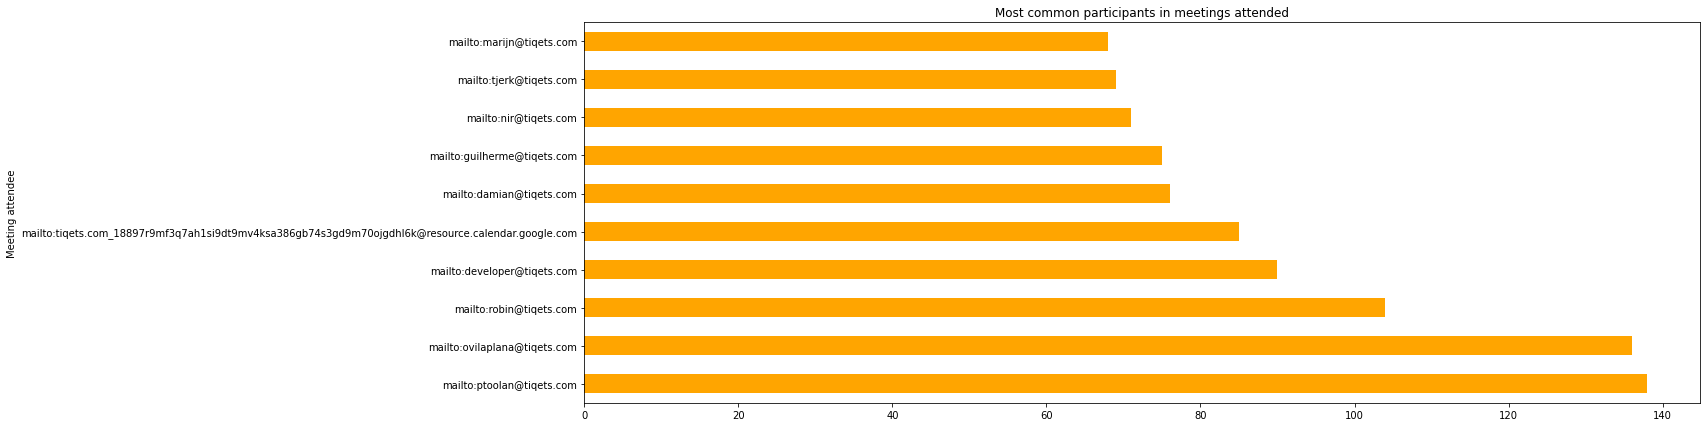

In [12]:
# Plot top 10 meeting organizers by number of meetings

plt.figure()
df['ORGANIZER'].str.replace('mailto:', '').value_counts()[1:11].plot(
    kind='barh', 
    color='gold',
    title='Most common organizers for meetings attended',
    ylabel='% Meetings (by count)', 
    xlabel='Meeting organizer',
    figsize=(20,7)
)

# Plot top 10 meeting co-attendees by number of meetings
plt.figure()
df.explode('ATTENDEE', ignore_index=True)['ATTENDEE'].value_counts()[1:11].plot(
    kind='barh', 
    color='orange',
    title='Most common participants in meetings attended',
    ylabel='% Meetings (by count)', 
    xlabel='Meeting attendee',
    figsize=(20,7)
)